In [1]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)
from tqdm import tqdm
from util import save_topk_words

In [2]:
df = pd.read_csv("../data/transcripts_normalized.csv", header=0)
df.dropna(subset=["transcript"], inplace=True)
df.head()

,video_id,transcript
0,AAHiZ-c88ec,man im getting frustrated water heater deliver...
1,AEsRr-ZnzNc,start give shoutout rokukun vyonder harry stac...
2,AJpzk-aFZPU,test number alright okay oh go ground oh god c...
3,AONXX-h9SdI,gonna play something brand new album came octo...
4,AOZIY-AwsjM,music


In [3]:
def get_kmeans_clusters(X_embeddings: np.ndarray, n_clusters: int = 10):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(X_embeddings)
    return kmeans

In [4]:
def plot_pca(km, X_embeddings: np.ndarray, title, save=True):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_embeddings)
    plt.figure(figsize=(10, 5))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km.labels_, cmap="viridis", alpha=0.7)
    plt.colorbar(label="Label")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title(title)
    if save:
        plt.savefig(f"figures/emb_baseline_pca_{title}.png")
    plt.show()

In [5]:
cluster_sizes = list(range(10, 51))
df_all = df.copy()
df_less_than_100 = df[df["transcript"].str.split().str.len() < 100]
df_more_than_100 = df[df["transcript"].str.split().str.len() >= 100]

df_corporas = [df_all, df_less_than_100, df_more_than_100]
print(df_corporas[0].shape)
print(df_corporas[1].shape)
print(df_corporas[2].shape)

(2630, 2)
(1308, 2)
(1322, 2)


In [6]:
measures = [[], [], []]
kms = [[], [], []]

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# save embeddings once
print("Embedding transcripts...")
df_embeddings = []
for df_corpus in tqdm(df_corporas):
    embeddings = model.encode(df_corpus["transcript"].to_list(), convert_to_numpy=True)
    df_embeddings.append(embeddings)

print("Clustering transcripts...")
for n_clusters in tqdm(cluster_sizes):
    for i, df_corpus in enumerate(df_corporas):
        km = get_kmeans_clusters(df_embeddings[i], n_clusters)
        kms[i].append(km)
        measures[i].append(
            {
                "n_clusters": n_clusters,
                "inertia": km.inertia_,
                "silhouette_score": silhouette_score(df_embeddings[i], km.labels_),
                "davies_bouldin_score": davies_bouldin_score(
                    df_embeddings[i], km.labels_
                ),
                "calinski_harabasz_score": calinski_harabasz_score(
                    df_embeddings[i], km.labels_
                ),
            }
        )

Embedding transcripts...


100%|██████████| 3/3 [02:12<00:00, 44.07s/it]


Clustering transcripts...


  0%|          | 0/41 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/opt/anaconda3/envs/ytb/lib/python3.10/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
100%|██████████| 41/41 [00:37<00:00,  1.11it/s]


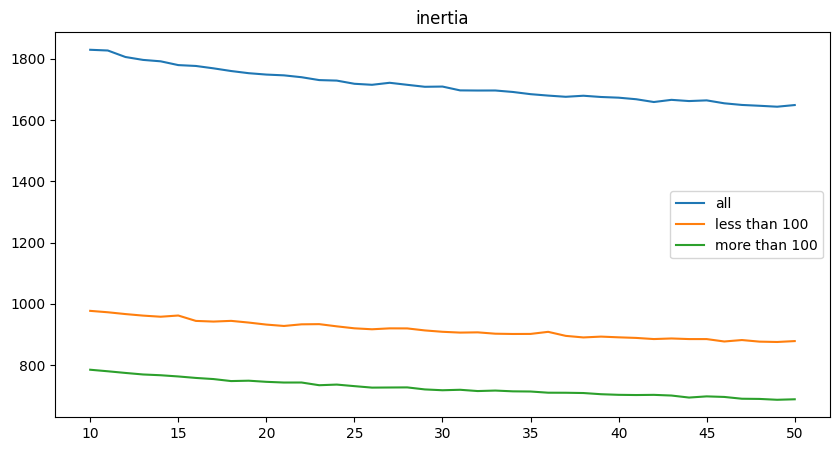

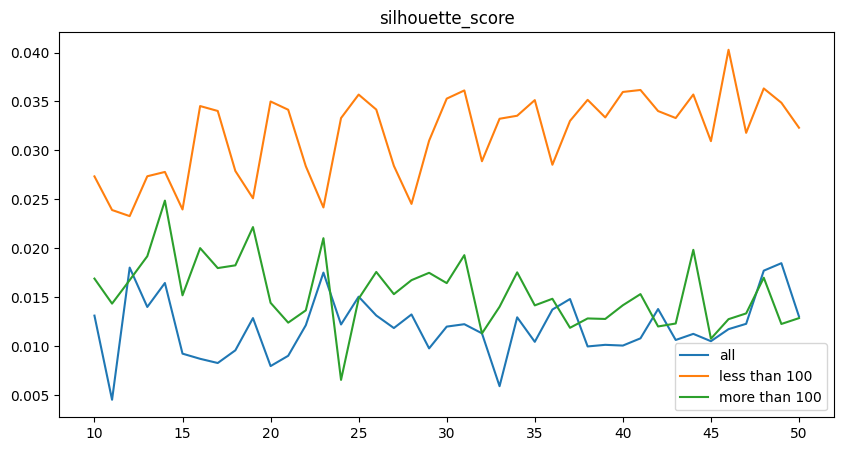

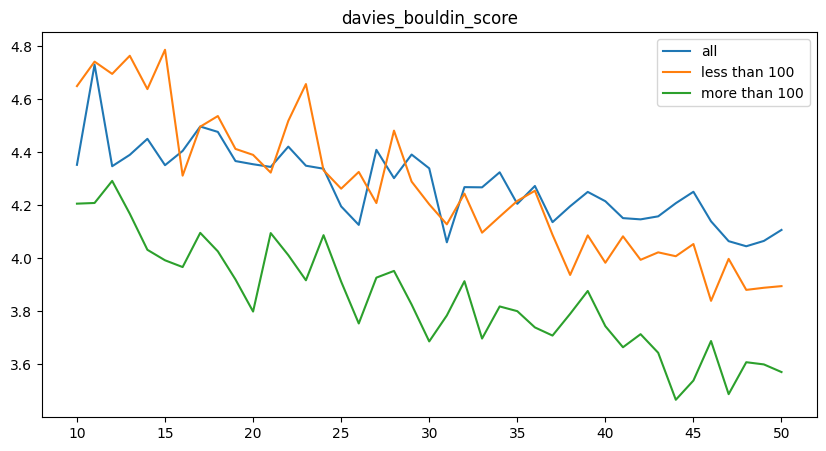

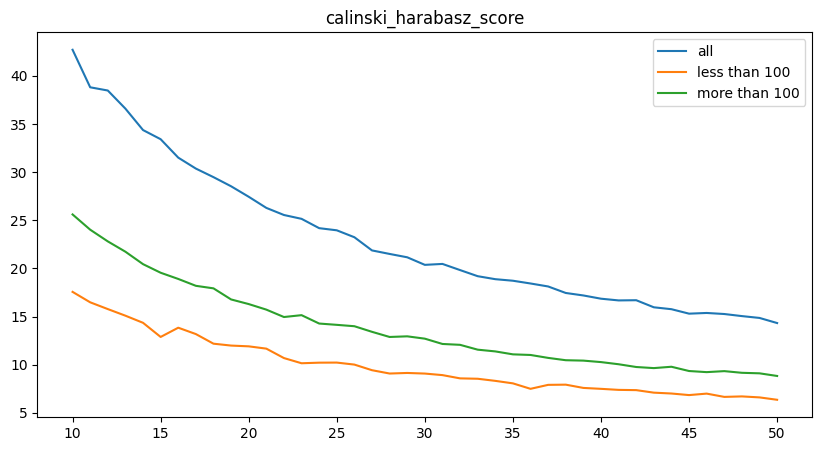

In [7]:
plot_attributes = [
    "inertia",
    "silhouette_score",
    "davies_bouldin_score",
    "calinski_harabasz_score",
]
labels = ["all", "less than 100", "more than 100"]
for attribute in plot_attributes:
    plt.figure(figsize=(10, 5))
    for i, df_corpus in enumerate(df_corporas):
        plt.plot(cluster_sizes, [m[attribute] for m in measures[i]], label=labels[i])
        plt.title(attribute)
    plt.legend()
    plt.savefig(f"../figures/emb_baseline_measure_{attribute}.png")
    plt.show()

In [8]:
save_topk_words("../topk/emb/emb", df_all, kms[0], 25, (10, 51, 1), True)

In [16]:
df = df_all
if "word_count" not in df.columns:
    df["word_count"] = df["transcript"].str.split().str.len()

for i in range(0, len(kms[0]), 10):
    labels = kms[0][i].labels_
    n_clusters = len(set(labels))

    print(f"\nFor k-means with {n_clusters} clusters:")

    for label in range(n_clusters):
        cluster_mask = labels == label
        cluster_lengths = df[cluster_mask]["word_count"]

        print(f"\nCluster {label}:")
        print(f"  Mean length: {cluster_lengths.mean():.1f}")
        print(f"  Median length: {cluster_lengths.median():.1f}")
        print(f"  Min length: {cluster_lengths.min()}")
        print(f"  Max length: {cluster_lengths.max()}")
        print(f"  Size: {len(cluster_lengths)} documents")


For k-means with 10 clusters:

Cluster 0:
  Mean length: 1050.6
  Median length: 450.0
  Min length: 67
  Max length: 17956
  Size: 410 documents

Cluster 1:
  Mean length: 24.4
  Median length: 8.0
  Min length: 1
  Max length: 568
  Size: 495 documents

Cluster 2:
  Mean length: 1213.7
  Median length: 503.0
  Min length: 28
  Max length: 21641
  Size: 277 documents

Cluster 3:
  Mean length: 2023.3
  Median length: 1515.5
  Min length: 12
  Max length: 19397
  Size: 92 documents

Cluster 4:
  Mean length: 103.3
  Median length: 42.0
  Min length: 4
  Max length: 12895
  Size: 498 documents

Cluster 5:
  Mean length: 151.3
  Median length: 55.0
  Min length: 2
  Max length: 4108
  Size: 216 documents

Cluster 6:
  Mean length: 440.2
  Median length: 223.0
  Min length: 7
  Max length: 17532
  Size: 194 documents

Cluster 7:
  Mean length: 148.6
  Median length: 60.0
  Min length: 1
  Max length: 4619
  Size: 149 documents

Cluster 8:
  Mean length: 712.0
  Median length: 306.0
  Min

In [9]:
# for i, km in enumerate(kms):
#     for j, k in enumerate(km):
#         if j % 5 == 0:
#             plot_pca(k, df_embeddings[i], f"PCA of {labels[i]} with {cluster_sizes[j]} clusters")

In [10]:
# kms[0][35].labels_.shape, kms[0][35]

In [11]:
# def save_topk_words(df, km, nc, k):
#     text_buffer = ""
#     cluster_words = []
#     for i in range(km.n_clusters):
#         cluster_mask = km.labels_ == i
#         cluster_docs = df[cluster_mask]["transcript"].tolist()

#         words = " ".join(cluster_docs).split()
#         wc = Counter(words)
#         top_words = wc.most_common(k)
#         cluster_words.append(top_words)

#         text_buffer += f"\nCluster {i} top {k} words:\n"
#         for w, c in top_words:
#             text_buffer += f"{w}: {c}\n"

#     with open(f"topk/emb/baseline_emb_{nc}_{k}.txt", "+w") as f:
#         f.write(text_buffer)

In [12]:
# for nc in range(10, 20):
#     idx = nc-10
#     save_topk_words(df_all, kms[0][idx], nc, 25)